In [1]:
# Imports!
# We likely will not end up using all of these, but better to have and not need.

import pandas as pd
import numpy as np
import gensim
import pickle
import regex as re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the clean dataframes

df = pd.read_csv('./data/combined.csv')
sandy = pd.read_csv('./data/sandy_clean_binary.csv')
oklahoma = pd.read_csv('./data/oklahoma_clean_binary.csv')
abflood = pd.read_csv('./data/abflood_clean_binary.csv')
qlflood = pd.read_csv('./data/qlflood_clean_binary.csv')

In [3]:
df.head()

,id,tweet,label,disaster
0,'262596552399396864',i ve got enough candles to supply a mexican fa...,0,hurricane
1,'263044104500420609',sandy be soooo mad that she be shattering our ...,1,hurricane
2,'263309629973491712',ibexgirl thankfully hurricane waugh played it...,0,hurricane
3,'263422851133079552',taos you never got that magnificent case of b...,0,hurricane
4,'262404311223504896',i m at mad river bar grille new york ny,0,hurricane


In [4]:
# Remove the first instance of rt for "retweet"

df['tweet'] = df['tweet'].map(lambda x: re.sub('rt', ' ', x, count=1).strip())
sandy['tweet'] = sandy['tweet'].map(lambda x: re.sub('rt', ' ', x, count=1).strip())
oklahoma['tweet'] = oklahoma['tweet'].map(lambda x: re.sub('rt', ' ', x, count=1).strip())
abflood['tweet'] = abflood['tweet'].map(lambda x: re.sub('rt', ' ', x, count=1).strip())
qlflood['tweet'] = qlflood['tweet'].map(lambda x: re.sub('rt', ' ', x, count=1).strip())

In [5]:
sandy.head()

,id,tweet,label,disaster
0,'262596552399396864',i ve got enough candles to supply a mexican fa...,0,hurricane
1,'263044104500420609',sandy be soooo mad that she be shattering our ...,1,hurricane
2,'263309629973491712',ibexgirl thankfully hurricane waugh played it ...,0,hurricane
3,'263422851133079552',taos you never got that magnificent case of bu...,0,hurricane
4,'262404311223504896',i m at mad river bar grille new york ny,0,hurricane


In [6]:
# Pre-Processing function from https://github.com/cameronbronstein/Project-4-New-Light-Technologies-Client-Project/blob/master/2%20-%20NLP_Urgency_Classification.ipynb
# This is a text preprocessing function that get our data ready for modeling, creating new columns 
# for the message text in their tokenized, lemmatized, and stemmed forms. This allows for easy selection
# of different forms of the text for use in vectorization and modeling.

def preprocessed_columns(dataframe = df, 
                        column = 'tweet', 
                        new_lemma_column = 'lemmatized', 
                        new_stem_column = 'stemmed',
                        new_token_column = 'tokenized',
                        regular_expression = r'\w+'): 
    
    tokenizer = RegexpTokenizer(regular_expression)      #Instantiate tokenizer with specific regular expression
    lemmatizer = WordNetLemmatizer()                     #Instantiate lemmatizer
    stemmer = PorterStemmer()                            #Instantiate stemmer
    
    lemmatized = []                                      #list to append lemmatized data
    stemmed = []                                         #list to append stemmed words
    tokenized = []
    
    
    for i in dataframe[column]:                          #Iterate through all the rows in specific column

        tokens = tokenizer.tokenize(i.lower())           #Converting string titles to tokens 
        tokenized.append(tokens)

        lemma = [lemmatizer.lemmatize(token) for token in tokens]     #lemmatizing all tokens
        lemmatized.append(lemma)                                      #appending lemma to lemmatized list

        stems = [stemmer.stem(token) for token in tokens]             #stemming all tokens
        stemmed.append(stems)                                         #creating stem list
     
    dataframe[new_token_column] = [' '.join(i) for i in tokenized]    
    dataframe[new_lemma_column] = [' '.join(i) for i in lemmatized]   #rejoing the lists for each title
    dataframe[new_stem_column] = [' '.join(i) for i in stemmed]       #setting results to be new columns in df   
    
    return dataframe

In [7]:
# Run our function to apply the above steps to our combined dataframe
processed = preprocessed_columns()

In [8]:
processed.head()

,id,tweet,label,disaster,tokenized,lemmatized,stemmed
0,'262596552399396864',i ve got enough candles to supply a mexican fa...,0,hurricane,i ve got enough candles to supply a mexican fa...,i ve got enough candle to supply a mexican family,i ve got enough candl to suppli a mexican famili
1,'263044104500420609',sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,sandy be soooo mad that she be shattering our ...,sandi be soooo mad that she be shatter our doo...
2,'263309629973491712',ibexgirl thankfully hurricane waugh played it ...,0,hurricane,ibexgirl thankfully hurricane waugh played it ...,ibexgirl thankfully hurricane waugh played it ...,ibexgirl thank hurrican waugh play it cool and...
3,'263422851133079552',taos you never got that magnificent case of bu...,0,hurricane,taos you never got that magnificent case of bu...,tao you never got that magnificent case of bur...,tao you never got that magnific case of burgun...
4,'262404311223504896',i m at mad river bar grille new york ny,0,hurricane,i m at mad river bar grille new york ny,i m at mad river bar grille new york ny,i m at mad river bar grill new york ny


In [9]:
# Run our processing function for each of the individual dataframes

sandy_p = preprocessed_columns(dataframe = sandy)
oklahoma_p = preprocessed_columns(dataframe = oklahoma)
abflood_p = preprocessed_columns(dataframe = abflood)
qlflood_p = preprocessed_columns(dataframe = oklahoma)

In [10]:
sandy_p.head()

,id,tweet,label,disaster,tokenized,lemmatized,stemmed
0,'262596552399396864',i ve got enough candles to supply a mexican fa...,0,hurricane,i ve got enough candles to supply a mexican fa...,i ve got enough candle to supply a mexican family,i ve got enough candl to suppli a mexican famili
1,'263044104500420609',sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,sandy be soooo mad that she be shattering our ...,sandi be soooo mad that she be shatter our doo...
2,'263309629973491712',ibexgirl thankfully hurricane waugh played it ...,0,hurricane,ibexgirl thankfully hurricane waugh played it ...,ibexgirl thankfully hurricane waugh played it ...,ibexgirl thank hurrican waugh play it cool and...
3,'263422851133079552',taos you never got that magnificent case of bu...,0,hurricane,taos you never got that magnificent case of bu...,tao you never got that magnificent case of bur...,tao you never got that magnific case of burgun...
4,'262404311223504896',i m at mad river bar grille new york ny,0,hurricane,i m at mad river bar grille new york ny,i m at mad river bar grille new york ny,i m at mad river bar grill new york ny


In [11]:
# Baseline of how many tweets are on-topic(1) and off-topic(0)
df['label'].value_counts()

1    21568
0    18496
Name: label, dtype: int64

# Word Count Visualization

## Combined Tweets

### Tokenized

In [12]:
# Instantiate a CountVectorizer removing english stopwords, ngram range of unigrams and bigrams
# Require words appear in a minimum of 25 tweets and do not appear in more than 95% of tweets

cv = CountVectorizer(stop_words = 'english',
                     ngram_range = (1,2),
                     min_df = 25,
                     max_df = .95)

In [13]:
# Create a dataframe of our CV transformed tokenized words

cv_df_token = pd.SparseDataFrame(cv.fit_transform(processed['tokenized']), 
                           columns = cv.get_feature_names())
cv_df_token.fillna(0, inplace=True)

In [14]:
cv_df_token.head()

,00,00 humidity,000,000 help,000 homes,000 people,10,10 donation,10 online,100,...,yycflood,yycflood abflood,yycflood relief,yycflood yyc,yycflood yychelps,yycfloods,yychelps,yychelps yycflood,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


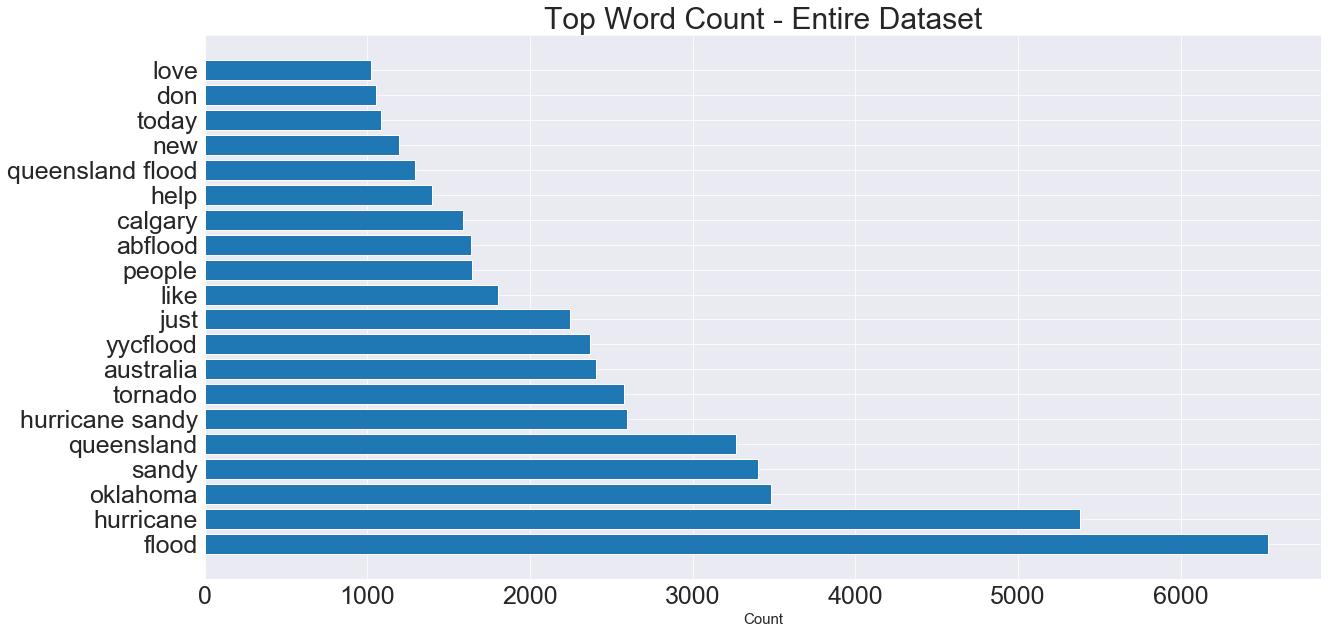

In [15]:
# Visualize the top occuring words in our 40,000 tweet dataset

plt.figure(figsize=(20, 10))
plt.barh(y = cv_df_token.sum().sort_values(ascending=False).head(20).index,
         width = cv_df_token.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count - Entire Dataset', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25);

In [16]:
# Split our dataframe into on-topic and off-topic
# We will use the on-topic tweets to determine urgency

df_ontopic = processed[processed['label'] == 1]
df_offtopic = processed[processed['label'] == 0]

print(df_ontopic.shape)
print(df_offtopic.shape)

(21568, 7)
(18496, 7)


In [17]:
# Create our dataframe of features obtained from our CountVectorizer

cv_dfontopic_token = pd.SparseDataFrame(cv.fit_transform(df_ontopic['tokenized']), 
                                        columns = cv.get_feature_names())
cv_dfontopic_token.fillna(0, inplace=True)

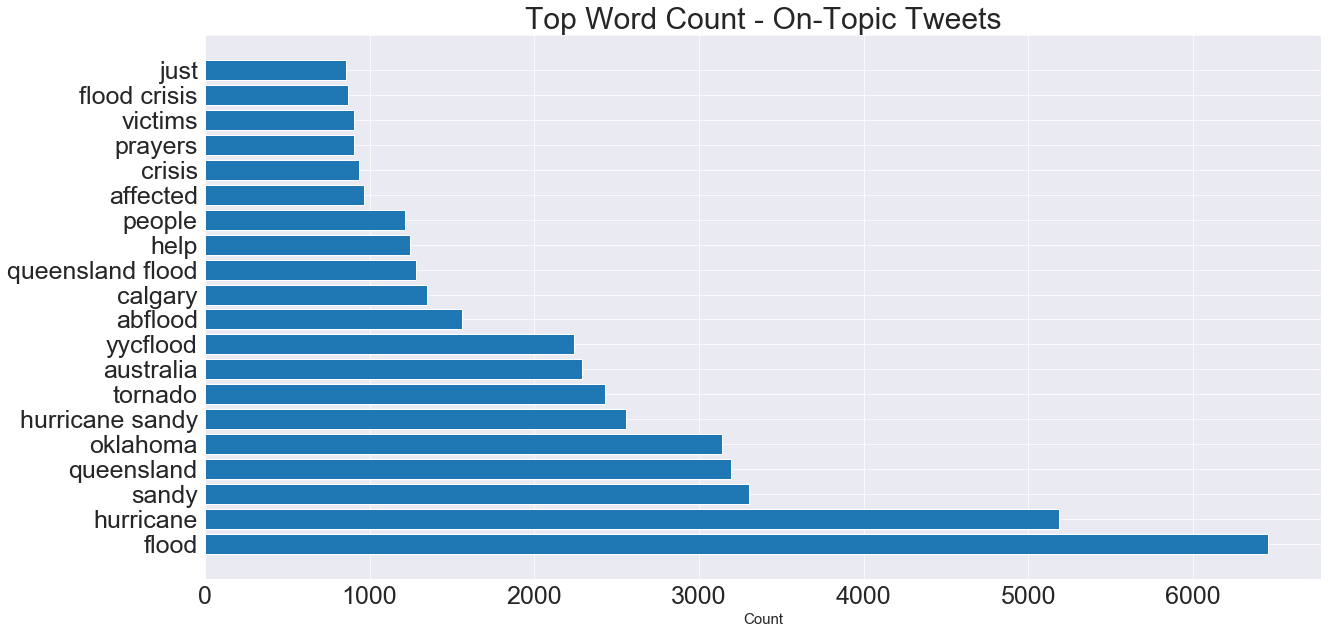

In [18]:
# Plot top 20 features

plt.figure(figsize=(20, 10))
plt.barh(y = cv_dfontopic_token.sum().sort_values(ascending=False).head(20).index,
         width = cv_dfontopic_token.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count - On-Topic Tweets', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25);

### Lemmatized

In [19]:
# This is the same thing we did above but for lemmatized words rather than tokenized

cv_lem = CountVectorizer(stop_words = 'english',
                         ngram_range = (1,2),
                         min_df = 25,
                         max_df = .95)

In [20]:
cv_df_lem = pd.SparseDataFrame(cv_lem.fit_transform(processed['lemmatized']),
                               columns = cv_lem.get_feature_names())
cv_df_lem.fillna(0, inplace=True)

In [21]:
cv_df_lem.head()

,00,00 humidity,000,000 help,000 home,000 people,10,10 donation,10 online,100,...,yycflood,yycflood abflood,yycflood relief,yycflood yyc,yycflood yychelps,yycfloods,yychelps,yychelps yycflood,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


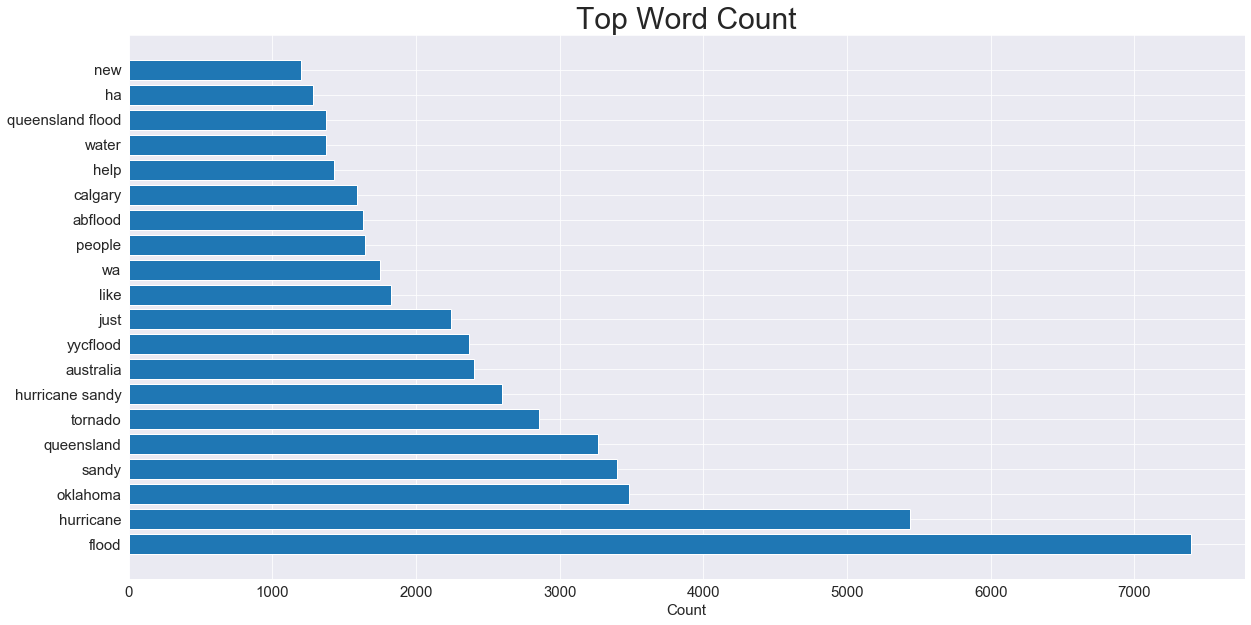

In [22]:
plt.figure(figsize=(20, 10))
plt.barh(y = cv_df_lem.sum().sort_values(ascending=False).head(20).index,
         width = cv_df_lem.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

### Stemmed

In [23]:
# This is the same thing we did for the tokenized above, but for stemmed words

cv_stem = CountVectorizer(stop_words = 'english',
                          ngram_range = (1,2),
                          min_df = 25,
                          max_df = .95)

In [24]:
cv_df_stem = pd.SparseDataFrame(cv_stem.fit_transform(processed['stemmed']),
                                columns = cv_stem.get_feature_names())
cv_df_stem.fillna(0, inplace=True)

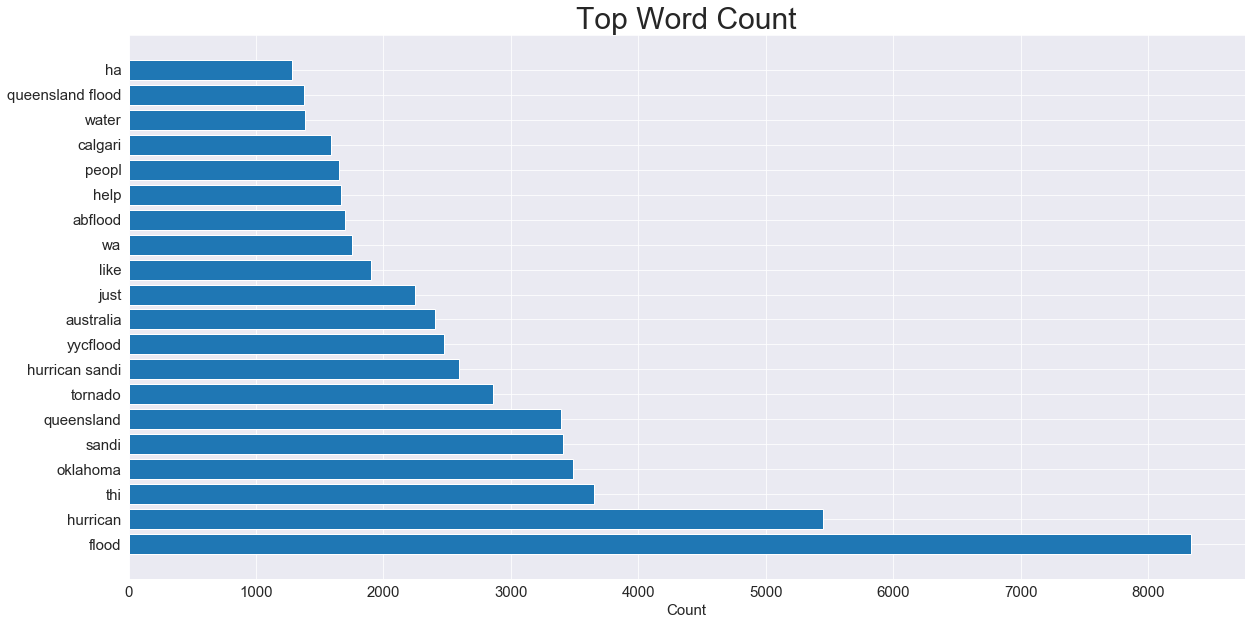

In [25]:
plt.figure(figsize=(20, 10))
plt.barh(y = cv_df_stem.sum().sort_values(ascending=False).head(20).index,
         width = cv_df_stem.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

## Sandy Tweets

In [26]:
# Splitting Sandy tweets specifically
# The below is the same thing we did above for the entire dataframe

sandy_ontopic = sandy_p[sandy_p['label'] == 1]
sandy_offtopic = sandy_p[sandy_p['label'] == 0]

In [27]:
sandy_ontopic.head()

,id,tweet,label,disaster,tokenized,lemmatized,stemmed
1,'263044104500420609',sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,sandy be soooo mad that she be shattering our ...,sandi be soooo mad that she be shatter our doo...
5,'263101347421888513',neighborly duties cory kennedy arrives to th...,1,hurricane,neighborly duties cory kennedy arrives to the ...,neighborly duty cory kennedy arrives to the re...,neighborli duti cori kennedi arriv to the resc...
7,'263298821189156865',i don t know how i m getting back to jersey si...,1,hurricane,i don t know how i m getting back to jersey si...,i don t know how i m getting back to jersey si...,i don t know how i m get back to jersey sinc t...
10,'262914476989358080',already flooded so much sandy hoboken,1,hurricane,already flooded so much sandy hoboken,already flooded so much sandy hoboken,alreadi flood so much sandi hoboken
12,'262991999911743490',on that note i pray that everyone stays safe ...,1,hurricane,on that note i pray that everyone stays safe a...,on that note i pray that everyone stay safe an...,on that note i pray that everyon stay safe and...


In [28]:
sandy_cv_df_token = pd.SparseDataFrame(cv.fit_transform(sandy_p['tokenized']),
                                       columns = cv.get_feature_names())
sandy_cv_df_token.fillna(0, inplace=True)

In [29]:
sandy_cv_df_token.head()

,000,000 help,10,100,100 retweets,11,2012,30,65,65 victims,...,yeah,year,years,yes,yesterday,yo,york,york city,york ny,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


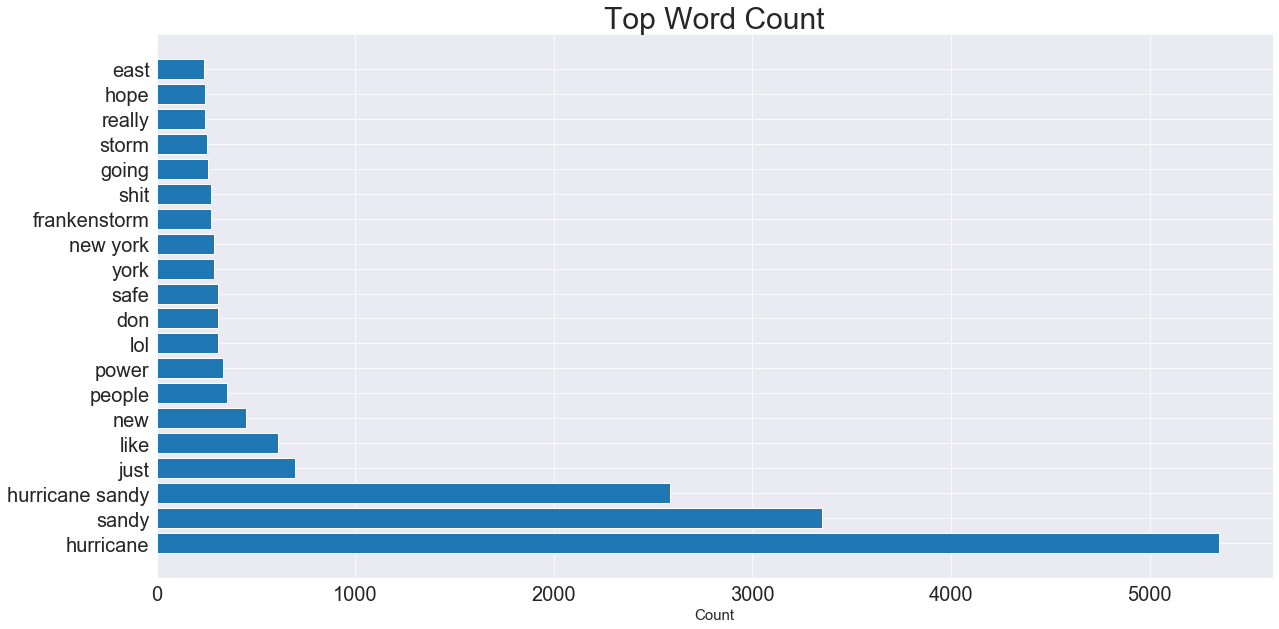

In [30]:
plt.figure(figsize=(20, 10))
plt.barh(y = sandy_cv_df_token.sum().sort_values(ascending=False).head(20).index,
         width = sandy_cv_df_token.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [31]:
sandyontopic_cv_df_token = pd.SparseDataFrame(cv.fit_transform(sandy_ontopic['tokenized']),
                                              columns = cv.get_feature_names())
sandyontopic_cv_df_token.fillna(0, inplace=True)

In [32]:
sandyontopic_cv_df_token.head()

,000,000 help,10,100,100 retweets,2012,30,65,65 victims,accounts,...,work,world,worried,worse,worst,wouldn,wow,yo,york,york city
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


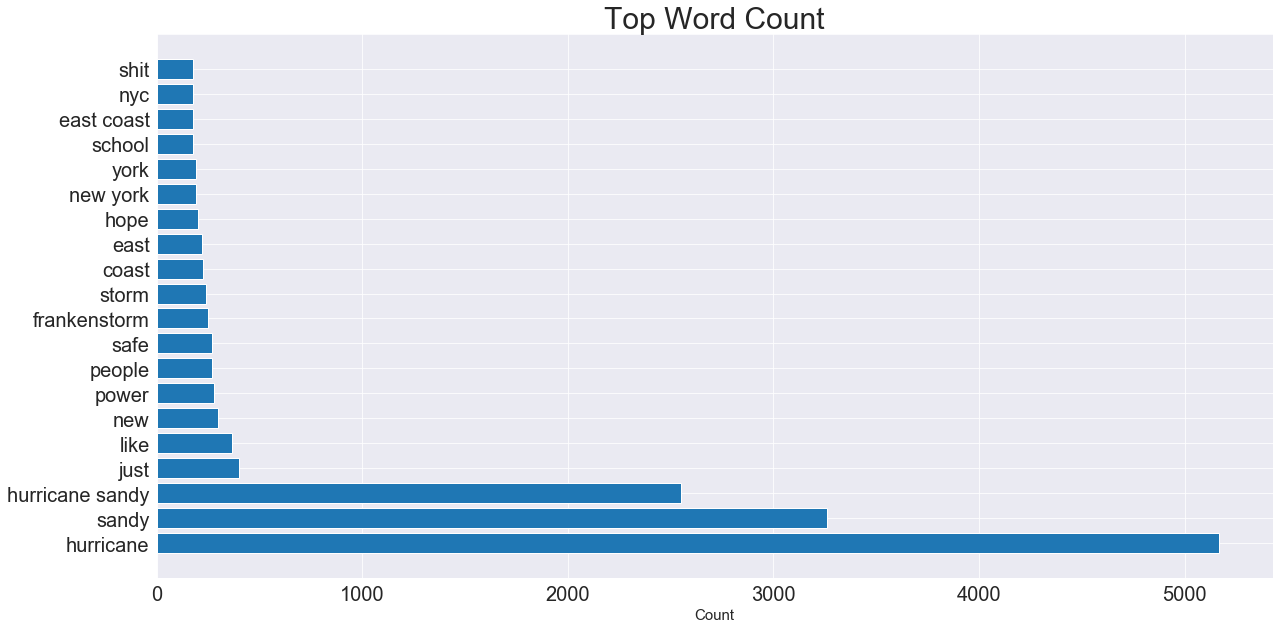

In [33]:
# These are the top features strictly for the on-topic tweets

plt.figure(figsize=(20, 10))
plt.barh(y = sandyontopic_cv_df_token.sum().sort_values(ascending=False).head(20).index,
         width = sandyontopic_cv_df_token.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## NLP to Determine Tweet Urgency

#### Below NLP work taken from https://github.com/belencito27/Map_Disasters_Twitter
#### DSI-DC Past Work

This is a  pre-trained vector trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.

We will use this to classify our on-topic tweets as either urgent or non-urgent based on the cosine similarities of the vectors created using a list of urgent / non-urgent words.

More information can be found [here](https://code.google.com/archive/p/word2vec/)

In [34]:
english_stops = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')

sandy_ontopic_tokens = [tokenizer.tokenize(tweet.lower()) for tweet in sandy_ontopic['tweet']]

clean_sandy_tweet_tokens = []
for tweet in sandy_ontopic_tokens:
    clean_tweet_tokens = []
    for word in tweet:
        if word not in english_stops and word not in ['@','rt', 'https',
                                                      'co', 'hurricanesandy'] and '@' not in word:
            clean_tweet_tokens.append(word)
    clean_sandy_tweet_tokens.append(clean_tweet_tokens)

In [35]:
# Import the vector necessary for our urgent/non-urgent vectors
# This is a pre-trained vector trained on part of Google News dataset (about 100 billion words). The model 
# contains 300-dimensional vectors for 3 million words and phrases.

# We will use this to classify our on-topic tweets as either urgent or non-urgent based on the cosine 
# similarities of the vectors created using a list of urgent / non-urgent words.

vec_mod = gensim.models.KeyedVectors.load_word2vec_format('~/Downloads/GoogleNews-vectors-negative300.bin',
                                                          binary=True)

In [36]:
# Create a list of the tokenized set of words from each tweet

english_stops = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')

df_ontopic_tokens = [tokenizer.tokenize(tweet.lower()) for tweet in df_ontopic['tweet']]

clean_df_tweet_tokens = []
for tweet in df_ontopic_tokens:
    clean_tweet_tokens = []
    for word in tweet:
        if word not in english_stops and word not in ['@','rt', 'https', 'co', 'hurricanesandy',
                                                      'yycflood', 'abflood'] and '@' not in word:
            clean_tweet_tokens.append(word)
    clean_df_tweet_tokens.append(clean_tweet_tokens)

In [37]:
# Lists altered from https://github.com/belencito27/Map_Disasters_Twitter
# Modified to better fit our data

####################
# HERE WE CREATE LISTS OF WORDS THAT WE THINK MAY INDICATE AN EMERGENCY, AND ANOTHER LIST OF WORDS THAT
#... WE THINK MAYBE LIKELY TO APPEAR IN NON-EMERGENCY TWEETS RELATED TO THE SAME NATURAL DISASTER. WE
#... WILL USE THESE LISTS OF WORDS TO CREATE VECTORS FOR Word2Vec COMPARISON IN THE NEXT FEW STEPS.
#... WE RECOMMEND USING SUBJECT MATTER EXPERTS TO DEVELOP APPROPRIATE WORD LISTS FOR THE GIVEN EVENT TYPE
#... (e.g. hurricane, tornado, flood (from our "testing" data (CrisisLex)))
####################

urgent = ['help', 'flood', 'leave', 'rescue', 'sos', 'danger', 'debris', 'removal', 'barrier', 'tree', 
          'feet', 'creek', 'removal', 'roads', 'levees', 'unsafe', 'structures', 'river',
          'water', 'floodplains', 'critical', 'evacuation', 'shelter', 'emergency', 'transport', 'access', 
          'safe', 'rescue', 'barricades', 'fire', 'generator', 'safety', 'hazard', 'need', 'lost', 'seen',
          'missing', 'flooding', 'reach', 'trying', 'now', 'attention', 'warning', 'alert', 'paramedics',
          'police', 'injuries', 'death', 'deaths', 'dead', 'collapse', 'damage', 'loss', 'burning']

non_urgent = ['help', 'vegetation', 'mud', 'silt', 'bridge', 'waterways', 'facility', 'utilities', 
              'park', 'traffic', 'replacement', 'control', 'repairs', 'stabilization', 'remediation', 
              'surfaces', 'bases', 'shoulders', 'ditches', 'drainage', 'sidewalk', ' guardrails', 'signs', 
              'decking', 'pavement', 'channel' ,'alignment', 'irrigation', 'erosion', 'prevention', 'dams', 
              'reservoirs', 'basins ', 'canals', 'aqueducts', 'coastal', 'shoreline', 'pumping', 'building', 
              'mechanical', 'electrical', 'basement', 'painting', ' treatment', 'power', 'transmission', 
              'natural gas', 'sewage', 'permanent', 'restoration', 'communication', 'systems', 'inspection', 
              'assessment', 'beach', 'park',  'playground', 'pool', 'docks', 'golf', 'tennis', 'ball', 'port', 
              'harbor', 'fish', 'hatcheries', 'insurance', 'habitat', 'temporary', 'heat', 'cold', 'hot']

In [38]:
# This is the urgent vector

urgent_vect = np.zeros((1,300))
counter=0
for word in urgent:
    if word not in vec_mod.vocab:
        continue
    else:
        temp = vec_mod.word_vec(word)
        urgent_vect=urgent_vect+temp
        counter +=1

urgent_vect=urgent_vect/counter
urgent_vect=np.squeeze(urgent_vect)
    #print(urgent_vect)

In [39]:
# This is the non-urgent vector

nonurgent_vect = np.zeros((1,300))
counter=0
for word in non_urgent:
    if word not in vec_mod.vocab:
        continue
    else:
        temp = vec_mod.word_vec(word)
        nonurgent_vect=nonurgent_vect+temp
        counter +=1

nonurgent_vect=nonurgent_vect/counter
nonurgent_vect=np.squeeze(nonurgent_vect)

#print(nonurgent_vect)

In [40]:
####################
# THIS IS THE NLP STEP. THE LOOP WILL TURN EACH WORD IN YOUR LIST OF TOKENIZED TWEETS (or 
#... tokenized sentences) INTO A VECTOR, CLASSIFY THE WORD AS EMERGENCY OR NON-EMERGENCY USING COSINE
#... SIMILARITY, AND ASSIGN THE ENTIRE TWEET (or sentence) A VALUE BASED OFF OF THE BASELINE CLASSIFICATION
#... SCORE.
####################

# This is code taken / borrowed from a previous DC-DSI project - credited below

sandy_target = [] # WE WILL FILL THIS WITH OUR CLASSIFICATIONS FOR EACH FULL TWEET
for tweet in clean_sandy_tweet_tokens:
    
    counter=0
    for item in tweet:
        
        temp_vect = np.zeros((1, 300))
        if item not in vec_mod.vocab.keys(): # IF WORD NOT IN Word2Vec MODEL, IT IS NOT INCLUDED
            continue
        else:
            temp_vect = temp_vect + vec_mod.word_vec(item)
            counter += 1
    if counter==0:
        counter=1
    temp_vect = np.squeeze(temp_vect)/counter
        
        # THE BELOW STEP IS CALCULATING AND COMPARING THE COSINE SIMILARITIES. THE DOT PRODUCT IS CALCULATED
        #... FOR THE TWEET VECTOR AND THE EMERGENCY VECTOR AND FOR THE TWEET VECTOR AND THE NON-EMERGENCY
        #... VECTOR. AFTER CALCULATING THE DOT PRODUCT, WE DIVIDE BY THE ABS. VALUE OF THE TWO GIVEN VECTORS
        #... TO GET THE COSINE VALUE FOR THE ANGLE BETWEEN THE VECTORS. THE GREATER THE COSINE VALUE, THE CLOSER
        #... TWO VECTORS ARE TO ONE ANOTHER, AND TWEETS ARE ASSIGNED A CLASSIFICATION OF EMERGENCY OR NON-
        #... EMERGENCY ACCORDINGLY
    if np.dot(temp_vect, urgent_vect)/(np.linalg.norm(urgent_vect)*np.linalg.norm(temp_vect)) >= np.dot(temp_vect,nonurgent_vect)/(np.linalg.norm(nonurgent_vect)*np.linalg.norm(temp_vect)):
        sandy_target.append(2)
    else:
        sandy_target.append(1)
        

In [41]:
# Set the labels of the on-topic tweets to 1 for non-urgent and 2 for urgent

sandy_ontopic['label'] = sandy_target

In [42]:
# Combine the on-topic urgent/non-urgent tweets with the off-topic tweets
sandy = pd.concat([sandy_ontopic, sandy_offtopic])

sandy.sort_index(inplace = True)

In [43]:
sandy.shape

(10008, 7)

In [44]:
sandy['label'].value_counts()

0    3870
2    3252
1    2886
Name: label, dtype: int64

In [45]:
# Save the file - uncomment to overwrite

# sandy.to_csv('./data/sandy_scored.csv', index = False)

## Logistic Regression for Tweet Qualification - On-topic, Off-topic

### This step will be used to determine whether tweets that have been newly gathered are on-topic or off-topic, using our CrisisLex tweets that are already labeled as on-topic or off-topic.

In [46]:
processed['label'].value_counts()

1    21568
0    18496
Name: label, dtype: int64

In [47]:
# Create our X and y variables

X = processed['tokenized']
y = processed['label']

In [48]:
# Null model

y.value_counts(normalize = True)

1    0.538339
0    0.461661
Name: label, dtype: float64

In [49]:
# Create a TfidfVectorizer that we'll apply for our NLP Classification model
# Ignore english stopwords, unigrams and bigrams, ignore words that appear in less than 25 tweets or more than 95%

tf = TfidfVectorizer(stop_words = 'english',
                     ngram_range = (1, 2),
                     max_df = .95,
                     min_df = 25)

In [50]:
# Transform our tokenized words into the TfidfVectorizer space

X_tf = tf.fit_transform(X)

In [51]:
# 2543 features
X_tf.shape

(40064, 2563)

In [52]:
# Split out X_tf and y, keeping the same y split

X_train, X_test, y_train, y_test = train_test_split(X_tf, y, test_size = 0.3, stratify = y)

In [53]:
X_train.shape

(28044, 2563)

In [54]:
X_test.shape

(12020, 2563)

In [55]:
# Instantiate our Logistic Regression model

lr = LogisticRegression()

In [56]:
# Fit on our training data
# Commented out so as not to re-fit the model

# lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
# Scored on our training data - 94.897 accuracy

lr.score(X_train, y_train)

0.9496862073883897

In [58]:
# Scored on our testing (previously unseen) data - 94.13% accuracy

lr.score(X_test, y_test)

0.9412645590682196

In [59]:
# Save our logistic regression model to be able to use it later
# Uncomment the lines below to overwrite our pickled model.

# classify_ontopic = 'lr.pkl'
# with open(classify_ontopic, 'wb') as file:
#     pickle.dump(lr, file)

In [60]:
####################
# THIS IS THE NLP STEP. THE LOOP WILL TURN EACH WORD IN YOUR LIST OF TOKENIZED TWEETS (or 
#... tokenized sentences) INTO A VECTOR, CLASSIFY THE WORD AS EMERGENCY OR NON-EMERGENCY USING COSINE
#... SIMILARITY, AND ASSIGN THE ENTIRE TWEET (or sentence) A VALUE BASED OFF OF THE BASELINE CLASSIFICATION
#... SCORE.
####################

target = [] # WE WILL FILL THIS WITH OUR CLASSIFICATIONS FOR EACH FULL TWEET
for tweet in clean_df_tweet_tokens:
    
    counter=0
    for item in tweet:
        
        temp_vect = np.zeros((1, 300))
        if item not in vec_mod.vocab.keys(): # IF WORD NOT IN Word2Vec MODEL, IT IS NOT INCLUDED
            continue
        else:
            temp_vect = temp_vect + vec_mod.word_vec(item)
            counter += 1
    if counter==0:
        counter=1
    temp_vect = np.squeeze(temp_vect)/counter
        
        # THE BELOW STEP IS CALCULATING AND COMPARING THE COSINE SIMILARITIES. THE DOT PRODUCT IS CALCULATED
        #... FOR THE TWEET VECTOR AND THE EMERGENCY VECTOR AND FOR THE TWEET VECTOR AND THE NON-EMERGENCY
        #... VECTOR. AFTER CALCULATING THE DOT PRODUCT, WE DIVIDE BY THE ABS. VALUE OF THE TWO GIVEN VECTORS
        #... TO GET THE COSINE VALUE FOR THE ANGLE BETWEEN THE VECTORS. THE GREATER THE COSINE VALUE, THE CLOSER
        #... TWO VECTORS ARE TO ONE ANOTHER, AND TWEETS ARE ASSIGNED A CLASSIFICATION OF EMERGENCY OR NON-
        #... EMERGENCY ACCORDINGLY
    if np.dot(temp_vect, urgent_vect)/(np.linalg.norm(urgent_vect)*np.linalg.norm(temp_vect)) >= np.dot(temp_vect,nonurgent_vect)/(np.linalg.norm(nonurgent_vect)*np.linalg.norm(temp_vect)):
        target.append(2)
    else:
        target.append(1)

In [61]:
len(target)

21568

In [62]:
# Modify our 'label' column for the ontopic dataframe to modify the on-topic tweets as either urgent or non-urgent

df_ontopic['label'] = target

In [63]:
df_ontopic.head()

,id,tweet,label,disaster,tokenized,lemmatized,stemmed
1,'263044104500420609',sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,sandy be soooo mad that she be shattering our ...,sandi be soooo mad that she be shatter our doo...
5,'263101347421888513',neighborly duties cory kennedy arrives to th...,2,hurricane,neighborly duties cory kennedy arrives to the ...,neighborly duty cory kennedy arrives to the re...,neighborli duti cori kennedi arriv to the resc...
7,'263298821189156865',i don t know how i m getting back to jersey si...,1,hurricane,i don t know how i m getting back to jersey si...,i don t know how i m getting back to jersey si...,i don t know how i m get back to jersey sinc t...
10,'262914476989358080',already flooded so much sandy hoboken,1,hurricane,already flooded so much sandy hoboken,already flooded so much sandy hoboken,alreadi flood so much sandi hoboken
12,'262991999911743490',on that note i pray that everyone stays safe ...,1,hurricane,on that note i pray that everyone stays safe a...,on that note i pray that everyone stay safe an...,on that note i pray that everyon stay safe and...


In [64]:
# Combine our revised ontopic dataframe with the offtopic dataframe
# 0 represents off-topic, 1 represents on-topic and low urgency, 2 represents on-topic and high urgency

df = pd.concat([df_ontopic, df_offtopic])

df.sort_index(inplace = True)

In [65]:
df.head()

,id,tweet,label,disaster,tokenized,lemmatized,stemmed
0,'262596552399396864',i ve got enough candles to supply a mexican fa...,0,hurricane,i ve got enough candles to supply a mexican fa...,i ve got enough candle to supply a mexican family,i ve got enough candl to suppli a mexican famili
1,'263044104500420609',sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,sandy be soooo mad that she be shattering our ...,sandi be soooo mad that she be shatter our doo...
2,'263309629973491712',ibexgirl thankfully hurricane waugh played it ...,0,hurricane,ibexgirl thankfully hurricane waugh played it ...,ibexgirl thankfully hurricane waugh played it ...,ibexgirl thank hurrican waugh play it cool and...
3,'263422851133079552',taos you never got that magnificent case of bu...,0,hurricane,taos you never got that magnificent case of bu...,tao you never got that magnificent case of bur...,tao you never got that magnific case of burgun...
4,'262404311223504896',i m at mad river bar grille new york ny,0,hurricane,i m at mad river bar grille new york ny,i m at mad river bar grille new york ny,i m at mad river bar grill new york ny


In [66]:
df['id'] = df['id'].str.replace("'", "")

In [67]:
df['id'] = df['id'].astype(int)

In [68]:
df.head(10)

,id,tweet,label,disaster,tokenized,lemmatized,stemmed
0,262596552399396864,i ve got enough candles to supply a mexican fa...,0,hurricane,i ve got enough candles to supply a mexican fa...,i ve got enough candle to supply a mexican family,i ve got enough candl to suppli a mexican famili
1,263044104500420609,sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,sandy be soooo mad that she be shattering our ...,sandi be soooo mad that she be shatter our doo...
2,263309629973491712,ibexgirl thankfully hurricane waugh played it ...,0,hurricane,ibexgirl thankfully hurricane waugh played it ...,ibexgirl thankfully hurricane waugh played it ...,ibexgirl thank hurrican waugh play it cool and...
3,263422851133079552,taos you never got that magnificent case of bu...,0,hurricane,taos you never got that magnificent case of bu...,tao you never got that magnificent case of bur...,tao you never got that magnific case of burgun...
4,262404311223504896,i m at mad river bar grille new york ny,0,hurricane,i m at mad river bar grille new york ny,i m at mad river bar grille new york ny,i m at mad river bar grill new york ny
5,263101347421888513,neighborly duties cory kennedy arrives to th...,2,hurricane,neighborly duties cory kennedy arrives to the ...,neighborly duty cory kennedy arrives to the re...,neighborli duti cori kennedi arriv to the resc...
6,262763437325684736,and that s it until the spring,0,hurricane,and that s it until the spring,and that s it until the spring,and that s it until the spring
7,263298821189156865,i don t know how i m getting back to jersey si...,1,hurricane,i don t know how i m getting back to jersey si...,i don t know how i m getting back to jersey si...,i don t know how i m get back to jersey sinc t...
8,262813023515865088,naeempeena we were asked to get off the plane ...,0,hurricane,naeempeena we were asked to get off the plane ...,naeempeena we were asked to get off the plane ...,naeempeena we were ask to get off the plane af...
9,262998165282762752,jaytee 96 you must be crazy omg you tweeted ...,0,hurricane,jaytee 96 you must be crazy omg you tweeted so...,jaytee 96 you must be crazy omg you tweeted so...,jayte 96 you must be crazi omg you tweet somet...


In [69]:
# df.to_csv('./data/combined_processed_classified.csv', index = False)

## Hurricane Harvey Houston and LA Earthquake

### The processes below are replicating what was done above but for other datasets / natural disasters.

### LA Earthquake

In [70]:
la = pd.read_csv('./data/la_earthquake2019_25mi.csv')
houston = pd.read_csv('./data/harveyhouston_20km.csv')

In [71]:
la.drop(['date', 'geo', 'hashtags', 'type', 'username'], axis = 1, inplace = True)

In [72]:
houston.drop(['date', 'geo', 'hashtags', 'username'], axis = 1, inplace = True)

In [73]:
la.head()

,id,text
0,1148016711699841025,thanks Rob! i am okay just thought i was havin...
1,1148014419504295936,Today in my yoga class we started with a fanta...
2,1148008868837904384,Lemme nut in you before this earthquake kill u...
3,1148006529729273857,This is what surviving Anime Expo and multiple...
4,1148004869564878848,A major earthquake is going to hit the along t...


In [74]:
la.rename(columns = {'text': 'tweet'}, inplace = True)
houston.rename(columns = {'text': 'tweet'}, inplace = True)

In [75]:
houston[houston.tweet.str.contains('http')][['tweet']].head()

,tweet
1,Hurricane Harvey Could Unleash 3 Feet of Rain ...
5,"6:44pm on #Harvey: ""moving at just 2 mph to th..."
8,"Harvey, now a tropical storm, drenches Texas a..."
9,Dogs and Cats Threatened by Hurricane Harvey! ...
12,Resourceful dog walks away with bag of dog foo...


In [76]:
houston.isnull().sum()

id       0
lat      0
long     0
tweet    0
dtype: int64

In [77]:
la.dropna(inplace = True)

In [78]:
la.isnull().sum()

id       0
tweet    0
dtype: int64

In [79]:
# Apply the cleaning from our cleaning notebook to our la dataframe
la['tweet'] = la['tweet'].map(lambda x: re.sub('http.+\/', ' ', x))
la['tweet'] = la['tweet'].map(lambda x: re.sub('http.+%2', ' ', x))
la['tweet'] = la['tweet'].map(lambda x: re.sub('rt', ' ', x, count=1).strip())
la['tweet'] = la['tweet'].str.replace('&amp;', '').str.strip()
la['tweet'] = la.tweet.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
la['tweet'] = la.tweet.apply(lambda x: x.lower())
la['tweet'] = la['tweet'].map(lambda x: re.sub('twitter', ' ', x).strip())
la['tweet'] = la['tweet'].map(lambda x: re.sub('com', ' ', x).strip())

# Apply the cleaning from our cleaning notebook to our houston dataframe
houston['tweet'] = houston['tweet'].map(lambda x: re.sub('http.+\/', ' ', x))
houston['tweet'] = houston['tweet'].map(lambda x: re.sub('http.+%2', ' ', x))
houston['tweet'] = houston['tweet'].map(lambda x: re.sub('rt', ' ', x, count=1).strip())
houston['tweet'] = houston.tweet.str.replace('&amp;', '').str.strip()
houston['tweet'] = houston.tweet.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
houston['tweet'] = houston.tweet.apply(lambda x: x.lower())
houston['tweet'] = houston['tweet'].map(lambda x: re.sub('twitter', ' ', x).strip())
houston['tweet'] = houston['tweet'].map(lambda x: re.sub('com', ' ', x).strip())

In [80]:
pd.set_option('max_colwidth', 50)

In [81]:
houston[houston.tweet.str.contains('twitter')][['tweet']]

,tweet


In [82]:
houston.isnull().sum()

id       0
lat      0
long     0
tweet    0
dtype: int64

In [83]:
# Process our la and houston dataframes

la_processed = preprocessed_columns(dataframe = la)
houston_processed = preprocessed_columns(dataframe = houston)

In [84]:
# Transform our la and houston 'tokenized' columns to prepare for on/off topic classification

tf_la = tf.transform(la_processed['tokenized'])
tf_houston = tf.transform(houston_processed['tokenized'])

In [85]:
# Make predictions as to whether tweets are "on topic" or "off topic"

la_processed['label'] = lr.predict(tf_la)
houston_processed['label'] = lr.predict(tf_houston)

In [86]:
# Given that our "training" data was from floods, hurricanes, and tornados, it does not come as a surprise
# that our model is not good at predicting whether earthquake data is on topic

la_processed['label'].value_counts()

0    11831
1       96
Name: label, dtype: int64

In [87]:
la_processed.shape

(11927, 6)

In [88]:
# Our model predicted 10766 tweets out of 15000 as "on topic" and 4234 as "off topic"

houston_processed['label'].value_counts()

1    10766
0     4234
Name: label, dtype: int64

In [89]:
houston_processed.head()

,id,lat,long,tweet,tokenized,lemmatized,stemmed,label
0,901595110210723840,29.7604,-95.3698,harvey broke our neighbor s tree one younger ...,harvey broke our neighbor s tree one younger b...,harvey broke our neighbor s tree one younger b...,harvey broke our neighbor s tree one younger b...,0
1,901595105680916482,29.7604,-95.3698,hurricane harvey could unleash 3 feet of rain ...,hurricane harvey could unleash 3 feet of rain ...,hurricane harvey could unleash 3 foot of rain ...,hurrican harvey could unleash 3 feet of rain a...,1
2,901595104321921025,29.7604,-95.3698,7 pm briefing to begin day 2 of 12 hr harvey o...,7 pm briefing to begin day 2 of 12 hr harvey o...,7 pm briefing to begin day 2 of 12 hr harvey o...,7 pm brief to begin day 2 of 12 hr harvey op h...,0
3,901595098626093056,29.7604,-95.3698,damn i m late on this hurricane,damn i m late on this hurricane,damn i m late on this hurricane,damn i m late on thi hurrican,1
4,901595097887686656,29.7604,-95.3698,lmao dude on the hurricane harvey snap story h...,lmao dude on the hurricane harvey snap story h...,lmao dude on the hurricane harvey snap story h...,lmao dude on the hurrican harvey snap stori ha...,1


In [90]:
houston_processed['label'].value_counts()

1    10766
0     4234
Name: label, dtype: int64

In [91]:
# houston_processed.to_csv('./data/houston_predicted.csv', index = False)

In [92]:
la_processed.head()

,id,tweet,tokenized,lemmatized,stemmed,label
0,1148016711699841025,thanks rob i am okay just thought i was havin...,thanks rob i am okay just thought i was having...,thanks rob i am okay just thought i wa having ...,thank rob i am okay just thought i wa have a s...,0
1,1148014419504295936,today in my yoga class we sta ed with a fantas...,today in my yoga class we sta ed with a fantas...,today in my yoga class we sta ed with a fantas...,today in my yoga class we sta ed with a fantas...,0
2,1148008868837904384,lemme nut in you before this ea hquake kill us...,lemme nut in you before this ea hquake kill us...,lemme nut in you before this ea hquake kill u ...,lemm nut in you befor thi ea hquak kill us both,0
3,1148006529729273857,this is what surviving anime expo and multiple...,this is what surviving anime expo and multiple...,this is what surviving anime expo and multiple...,thi is what surviv anim expo and multipl ea hq...,0
4,1148004869564878848,a major ea hquake is going to hit the along th...,a major ea hquake is going to hit the along th...,a major ea hquake is going to hit the along th...,a major ea hquak is go to hit the along the so...,0


In [93]:
# la_processed.to_csv('./data/laquake_predicted.csv', index = False)

### Hurricane Harvey Houston

In [94]:
cv_htown = CountVectorizer(stop_words = 'english',
                           ngram_range = (1,2),
                           min_df = 25,
                           max_df = .95)

In [95]:
cv_df_htown = pd.SparseDataFrame(cv_htown.fit_transform(houston_processed['tokenized']),
                                 columns = cv_htown.get_feature_names())
cv_df_htown.fillna(0, inplace=True)

In [96]:
cv_df_htown.head()

,00,000,01pm,01pm 26,08,08 26,10,10 17pm,11,11 01pm,...,wx id1102231742,ya,yeah,year,years,yes,yes entire,yesterday,youtube,youtube video
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


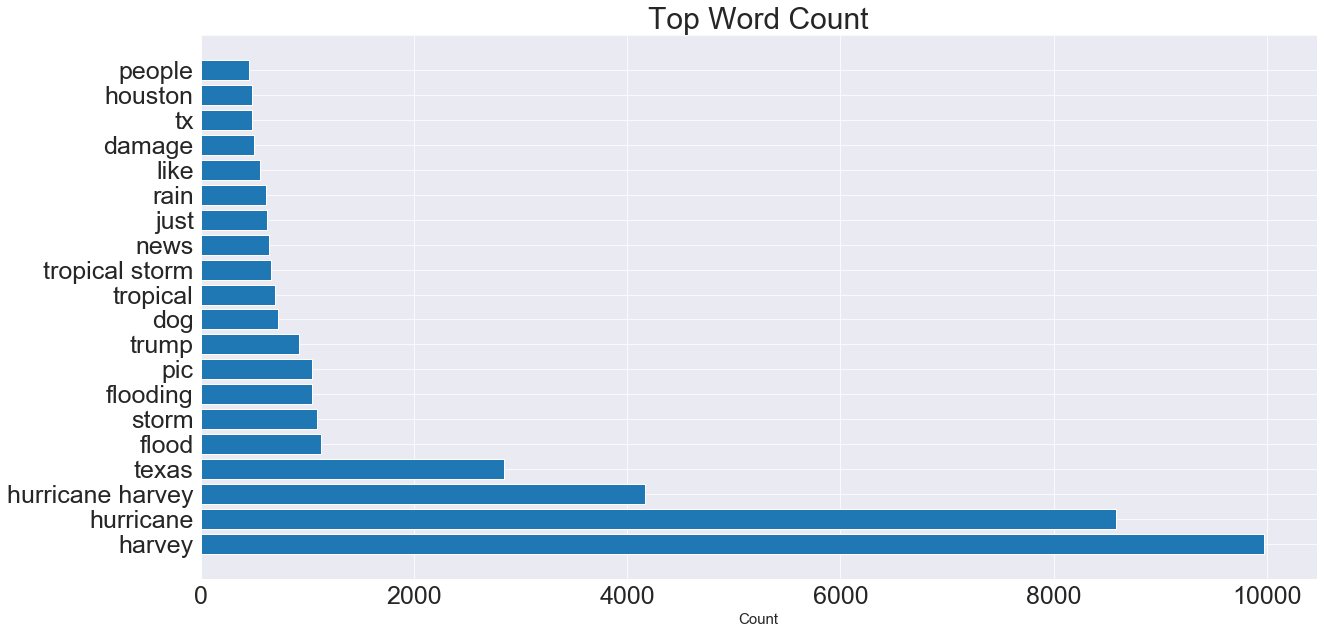

In [97]:
plt.figure(figsize=(20, 10))
plt.barh(y = cv_df_htown.sum().sort_values(ascending=False).head(20).index,
         width = cv_df_htown.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25);

In [98]:
harvey_on = houston_processed[houston_processed['label'] == 1]
harvey_off = houston_processed[houston_processed['label'] == 0]

In [99]:
english_stops = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')

harvey_ontopic_tokens = [tokenizer.tokenize(tweet.lower()) for tweet in harvey_on['tweet']]

clean_harvey_tweet_tokens = []
for tweet in harvey_ontopic_tokens:
    clean_tweet_tokens = []
    for word in tweet:
        if word not in english_stops and word not in ['hurricaneharvey', 'harvey'] and '@' not in word:
            clean_tweet_tokens.append(word)
    clean_harvey_tweet_tokens.append(clean_tweet_tokens)

In [100]:
####################
# THIS IS THE NLP STEP. THE LOOP WILL TURN EACH WORD IN YOUR LIST OF TOKENIZED TWEETS (or 
#... tokenized sentences) INTO A VECTOR, CLASSIFY THE WORD AS EMERGENCY OR NON-EMERGENCY USING COSINE
#... SIMILARITY, AND ASSIGN THE ENTIRE TWEET (or sentence) A VALUE BASED OFF OF THE BASELINE CLASSIFICATION
#... SCORE.
####################

target_harvey = [] # WE WILL FILL THIS WITH OUR CLASSIFICATIONS FOR EACH FULL TWEET
for tweet in clean_harvey_tweet_tokens:
    
    counter=0
    for item in tweet:
        
        temp_vect = np.zeros((1, 300))
        if item not in vec_mod.vocab.keys(): # IF WORD NOT IN Word2Vec MODEL, IT IS NOT INCLUDED
            continue
        else:
            temp_vect = temp_vect + vec_mod.word_vec(item)
            counter += 1
    if counter==0:
        counter=1
    temp_vect = np.squeeze(temp_vect)/counter
        
        # THE BELOW STEP IS CALCULATING AND COMPARING THE COSINE SIMILARITIES. THE DOT PRODUCT IS CALCULATED
        #... FOR THE TWEET VECTOR AND THE EMERGENCY VECTOR AND FOR THE TWEET VECTOR AND THE NON-EMERGENCY
        #... VECTOR. AFTER CALCULATING THE DOT PRODUCT, WE DIVIDE BY THE ABS. VALUE OF THE TWO GIVEN VECTORS
        #... TO GET THE COSINE VALUE FOR THE ANGLE BETWEEN THE VECTORS. THE GREATER THE COSINE VALUE, THE CLOSER
        #... TWO VECTORS ARE TO ONE ANOTHER, AND TWEETS ARE ASSIGNED A CLASSIFICATION OF EMERGENCY OR NON-
        #... EMERGENCY ACCORDINGLY
    if np.dot(temp_vect, urgent_vect)/(np.linalg.norm(urgent_vect)*np.linalg.norm(temp_vect)) >= np.dot(temp_vect,nonurgent_vect)/(np.linalg.norm(nonurgent_vect)*np.linalg.norm(temp_vect)):
        target_harvey.append(2)
    else:
        target_harvey.append(1)

In [101]:
harvey_on['label'] = target_harvey

In [102]:
harvey_on['label'].value_counts()

1    6930
2    3836
Name: label, dtype: int64

In [103]:
harvey = pd.concat([harvey_on, harvey_off])

harvey.sort_index(inplace = True)

In [104]:
harvey.shape

(15000, 8)

In [105]:
harvey['label'].value_counts()

1    6930
0    4234
2    3836
Name: label, dtype: int64

In [106]:
# harvey.to_csv('./data/harvey_scored.csv', index = False)

## Harvey No Search Terms

In [107]:
harvey_unfiltered = pd.read_csv('./data/harvey_unfilter.csv')

In [108]:
harvey_unfiltered.head()

,Unnamed: 0,id,username,date,text,hashtags,geo,type
0,0,901594938407739393,Cher2ification,2017-08-26 23:59:18+00:00,My hurricane sundae cookies and creme!! #hurri...,#hurricaneharvey #houston #tagsforlikes,NaN,official
1,1,901594810582171654,FredLin1028,2017-08-26 23:58:48+00:00,Ben & Jerry's @Ben & Jerry's https://www.insta...,NaN,NaN,official
2,2,901594244187545600,RickStarPhoto1,2017-08-26 23:56:33+00:00,When Wendell Williams uses your shot...Go Texa...,#Repost,NaN,official
3,3,901594032668856322,J_shadesyou,2017-08-26 23:55:42+00:00,WINNER #2 @DemChaLeo #JSHADES #GIVEAWAY #AMBAS...,#2 #JSHADES #GIVEAWAY #AMBASSADOR #Jshades,NaN,official
4,4,901593932055756800,MaykupJunkee,2017-08-26 23:55:18+00:00,If you have never heard of @ShopMissA thank me...,NaN,NaN,official


In [109]:
harvey_unfiltered.drop(['Unnamed: 0', 'username', 'date', 'hashtags', 'geo', 'type'], axis = 1, inplace = True)

In [110]:
harvey_unfiltered.rename(columns = {'text': 'tweet'}, inplace = True)

In [111]:
harvey_unfiltered.isnull().sum()

id       0
tweet    4
dtype: int64

In [112]:
harvey_unfiltered.dropna(inplace = True)

In [113]:
harvey_unfiltered[harvey_unfiltered.tweet.str.contains('http')][['tweet']].head()

,tweet
0,My hurricane sundae cookies and creme!! #hurri...
1,Ben & Jerry's @Ben & Jerry's https://www.insta...
2,When Wendell Williams uses your shot...Go Texa...
3,WINNER #2 @DemChaLeo #JSHADES #GIVEAWAY #AMBAS...
4,If you have never heard of @ShopMissA thank me...


In [114]:
harvey_unfiltered['tweet'] = harvey_unfiltered['tweet'].map(lambda x: re.sub('http.+\/', ' ', x))
harvey_unfiltered['tweet'] = harvey_unfiltered['tweet'].map(lambda x: re.sub('http.+%2', ' ', x))
harvey_unfiltered['tweet'] = harvey_unfiltered['tweet'].map(lambda x: re.sub('rt', ' ', x, count=1).strip())
harvey_unfiltered['tweet'] = harvey_unfiltered.tweet.str.replace('&amp;', '').str.strip()
harvey_unfiltered['tweet'] = harvey_unfiltered.tweet.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
harvey_unfiltered['tweet'] = harvey_unfiltered.tweet.apply(lambda x: x.lower())
harvey_unfiltered['tweet'] = harvey_unfiltered['tweet'].map(lambda x: re.sub('twitter', ' ', x).strip())
harvey_unfiltered['tweet'] = harvey_unfiltered['tweet'].map(lambda x: re.sub('com', ' ', x).strip())

In [115]:
pd.set_option('max_colwidth', 50)

In [116]:
harvey_unfiltered[harvey_unfiltered.tweet.str.contains('http')][['tweet']].head()

,tweet


In [117]:
hup = preprocessed_columns(dataframe = harvey_unfiltered)

In [118]:
tf_hup = tf.transform(hup['tokenized'])

In [119]:
hup['label'] = lr.predict(tf_hup)

In [120]:
hup['label'].value_counts()

0    2325
1     392
Name: label, dtype: int64

In [121]:
cv_hup = CountVectorizer(stop_words = 'english',
                           ngram_range = (1,2),
                           min_df = 25,
                           max_df = .95)

In [122]:
cv_df_hup = pd.SparseDataFrame(cv_hup.fit_transform(hup['tokenized']),
                                 columns = cv_hup.get_feature_names())
cv_df_hup.fillna(0, inplace=True)

In [123]:
cv_df_htown.head()

,00,000,01pm,01pm 26,08,08 26,10,10 17pm,11,11 01pm,...,wx id1102231742,ya,yeah,year,years,yes,yes entire,yesterday,youtube,youtube video
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


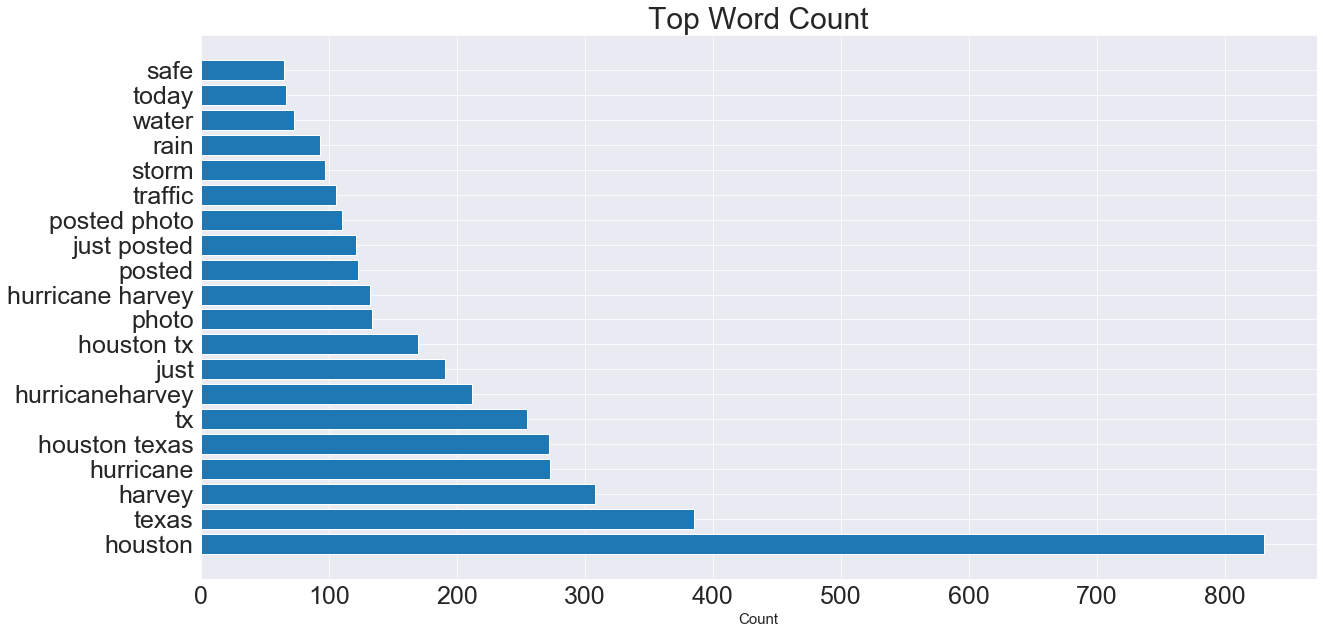

In [124]:
plt.figure(figsize=(20, 10))
plt.barh(y = cv_df_hup.sum().sort_values(ascending=False).head(20).index,
         width = cv_df_hup.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25);

In [125]:
hup_on = hup[hup['label'] == 1]
hup_off = hup[hup['label'] == 0]

In [126]:
english_stops = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')

hup_ontopic_tokens = [tokenizer.tokenize(tweet.lower()) for tweet in hup_on['tweet']]

clean_hup_tweet_tokens = []
for tweet in hup_ontopic_tokens:
    clean_tweet_tokens = []
    for word in tweet:
        if word not in english_stops and word not in ['hurricaneharvey', 'harvey'] and '@' not in word:
            clean_tweet_tokens.append(word)
    clean_hup_tweet_tokens.append(clean_tweet_tokens)

In [127]:
####################
# THIS IS THE NLP STEP. THE LOOP WILL TURN EACH WORD IN YOUR LIST OF TOKENIZED TWEETS (or 
#... tokenized sentences) INTO A VECTOR, CLASSIFY THE WORD AS EMERGENCY OR NON-EMERGENCY USING COSINE
#... SIMILARITY, AND ASSIGN THE ENTIRE TWEET (or sentence) A VALUE BASED OFF OF THE BASELINE CLASSIFICATION
#... SCORE.
####################

target_hup = [] # WE WILL FILL THIS WITH OUR CLASSIFICATIONS FOR EACH FULL TWEET
for tweet in clean_hup_tweet_tokens:
    
    counter=0
    for item in tweet:
        
        temp_vect = np.zeros((1, 300))
        if item not in vec_mod.vocab.keys(): # IF WORD NOT IN Word2Vec MODEL, IT IS NOT INCLUDED
            continue
        else:
            temp_vect = temp_vect + vec_mod.word_vec(item)
            counter += 1
    if counter==0:
        counter=1
    temp_vect = np.squeeze(temp_vect)/counter
        
        # THE BELOW STEP IS CALCULATING AND COMPARING THE COSINE SIMILARITIES. THE DOT PRODUCT IS CALCULATED
        #... FOR THE TWEET VECTOR AND THE EMERGENCY VECTOR AND FOR THE TWEET VECTOR AND THE NON-EMERGENCY
        #... VECTOR. AFTER CALCULATING THE DOT PRODUCT, WE DIVIDE BY THE ABS. VALUE OF THE TWO GIVEN VECTORS
        #... TO GET THE COSINE VALUE FOR THE ANGLE BETWEEN THE VECTORS. THE GREATER THE COSINE VALUE, THE CLOSER
        #... TWO VECTORS ARE TO ONE ANOTHER, AND TWEETS ARE ASSIGNED A CLASSIFICATION OF EMERGENCY OR NON-
        #... EMERGENCY ACCORDINGLY
    if np.dot(temp_vect, urgent_vect)/(np.linalg.norm(urgent_vect)*np.linalg.norm(temp_vect)) >= np.dot(temp_vect,nonurgent_vect)/(np.linalg.norm(nonurgent_vect)*np.linalg.norm(temp_vect)):
        target_hup.append(2)
    else:
        target_hup.append(1)
        

In [128]:
hup_on['label'] = target_hup

In [129]:
hup_on['label'].value_counts()

1    204
2    188
Name: label, dtype: int64

In [130]:
hup_labeled = pd.concat([hup_on, hup_off])

hup_labeled.sort_index(inplace = True)

In [131]:
hup_labeled['label'].value_counts()

0    2325
1     204
2     188
Name: label, dtype: int64

In [132]:
# hup_labeled.to_csv('./data/harvey_unfiltered_labeled.csv', index = False)

## Omaha

In [133]:
russ = pd.read_csv('./data/russ_test.csv')
russ.drop(['Unnamed: 0', 'username', 'date', 'hashtags', 'geo', 'type'], axis = 1, inplace = True)

In [134]:
russ.head()

,id,text
0,1107793693753438209,But he doesn’t get paid to play defense
1,1107793614728499201,Contact has been made between Nebraska and Hoi...
2,1107793592012165120,Thank you for an excellent chat @DrJacieMaslyk...
3,1107793315716648960,I can’t wait to marry Pete Davidson one day
4,1107792860986990599,https://www.instagram.com/p/BvKzq92hgLC/?utm_s...


In [135]:
russ.rename(columns = {'text': 'tweet'}, inplace = True)

In [136]:
russ.isnull().sum()

id        0
tweet    15
dtype: int64

In [137]:
russ.dropna(inplace = True)

In [138]:
russ.shape

(3268, 2)

In [139]:
russ['tweet'] = russ.tweet.str.replace('&amp;', '').str.strip()
russ['tweet'] = russ.tweet.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
russ['tweet'] = russ.tweet.apply(lambda x: x.lower())
russ['tweet'] = russ.tweet.map(lambda x: re.sub('http.+\/', ' ', x))
russ['tweet'] = russ.tweet.map(lambda x: re.sub('http.+%2', ' ', x))

In [140]:
russ_pro = preprocessed_columns(dataframe = russ)

In [141]:
russ_pro.head()

,id,tweet,tokenized,lemmatized,stemmed
0,1107793693753438209,but he doesn t get paid to play defense,but he doesn t get paid to play defense,but he doesn t get paid to play defense,but he doesn t get paid to play defens
1,1107793614728499201,contact has been made between nebraska and hoi...,contact has been made between nebraska and hoi...,contact ha been made between nebraska and hoib...,contact ha been made between nebraska and hoib...
2,1107793592012165120,thank you for an excellent chat drjaciemaslyk...,thank you for an excellent chat drjaciemaslyk ...,thank you for an excellent chat drjaciemaslyk ...,thank you for an excel chat drjaciemaslyk form...
3,1107793315716648960,i can t wait to marry pete davidson one day,i can t wait to marry pete davidson one day,i can t wait to marry pete davidson one day,i can t wait to marri pete davidson one day
4,1107792860986990599,https www instagram com p bvkzq92hglc utm s...,https www instagram com p bvkzq92hglc utm sour...,http www instagram com p bvkzq92hglc utm sourc...,http www instagram com p bvkzq92hglc utm sourc...


In [142]:
tf_russ = tf.transform(russ_pro['tokenized'])

In [143]:
russ_pro['label'] = lr.predict(tf_russ)

In [144]:
russ_pro['label'].value_counts()

0    3077
1     191
Name: label, dtype: int64

In [145]:
russ_pro_on = russ_pro[russ_pro['label'] == 1]
russ_pro_off = russ_pro[russ_pro['label'] == 0]

In [146]:
english_stops = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')

russ_ontopic_tokens = [tokenizer.tokenize(tweet.lower()) for tweet in russ_pro_on['tweet']]

clean_russ_tweet_tokens = []
for tweet in russ_ontopic_tokens:
    clean_tweet_tokens = []
    for word in tweet:
        if word not in english_stops and word not in ['@','rt', 'https', 'co'] and '@' not in word:
            clean_tweet_tokens.append(word)
    clean_russ_tweet_tokens.append(clean_tweet_tokens)

In [147]:
####################
# THIS IS THE NLP STEP. THE LOOP WILL TURN EACH WORD IN YOUR LIST OF TOKENIZED TWEETS (or 
#... tokenized sentences) INTO A VECTOR, CLASSIFY THE WORD AS EMERGENCY OR NON-EMERGENCY USING COSINE
#... SIMILARITY, AND ASSIGN THE ENTIRE TWEET (or sentence) A VALUE BASED OFF OF THE BASELINE CLASSIFICATION
#... SCORE.
####################

russ_target = [] # WE WILL FILL THIS WITH OUR CLASSIFICATIONS FOR EACH FULL TWEET
for tweet in clean_russ_tweet_tokens:
    
    counter=0
    for item in tweet:
        
        temp_vect = np.zeros((1, 300))
        if item not in vec_mod.vocab.keys(): # IF WORD NOT IN Word2Vec MODEL, IT IS NOT INCLUDED
            continue
        else:
            temp_vect = temp_vect + vec_mod.word_vec(item)
            counter += 1
    if counter==0:
        counter=1
    temp_vect = np.squeeze(temp_vect)/counter
        
        # THE BELOW STEP IS CALCULATING AND COMPARING THE COSINE SIMILARITIES. THE DOT PRODUCT IS CALCULATED
        #... FOR THE TWEET VECTOR AND THE EMERGENCY VECTOR AND FOR THE TWEET VECTOR AND THE NON-EMERGENCY
        #... VECTOR. AFTER CALCULATING THE DOT PRODUCT, WE DIVIDE BY THE ABS. VALUE OF THE TWO GIVEN VECTORS
        #... TO GET THE COSINE VALUE FOR THE ANGLE BETWEEN THE VECTORS. THE GREATER THE COSINE VALUE, THE CLOSER
        #... TWO VECTORS ARE TO ONE ANOTHER, AND TWEETS ARE ASSIGNED A CLASSIFICATION OF EMERGENCY OR NON-
        #... EMERGENCY ACCORDINGLY
    if np.dot(temp_vect, urgent_vect)/(np.linalg.norm(urgent_vect)*np.linalg.norm(temp_vect)) >= np.dot(temp_vect,nonurgent_vect)/(np.linalg.norm(nonurgent_vect)*np.linalg.norm(temp_vect)):
        russ_target.append(2)
    else:
        russ_target.append(1)

In [148]:
russ_pro_on['label'] = russ_target

In [149]:
russ_pro_on['label'].value_counts()

1    140
2     51
Name: label, dtype: int64

In [150]:
russ = pd.concat([russ_pro_on, russ_pro_off])

russ.sort_index(inplace = True)

In [151]:
russ.label.value_counts()

0    3077
1     140
2      51
Name: label, dtype: int64

In [152]:
# russ.to_csv('./data/russ_scored.csv', index = False)